# **Filtering and trimming messages**


In [1]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Retrieve the API key from the environment
groq_api_key = os.getenv("GROQ_API_KEY")

if groq_api_key is None:
    print("Groq API key is not set in the environment variables.")
else:
    print("Groq API key successfully loaded.")

Groq API key successfully loaded.


## Messages as state


In [2]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Zeeshan"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Zeeshan

Yes, I know about whales. But what others should I learn about?


In [3]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0)

llm.invoke(messages)

AIMessage(content='There are many fascinating ocean mammals beyond whales. Here are some examples:\n\n1. **Dolphins**: These intelligent and social creatures are closely related to whales and are known for their playful behavior.\n2. **Porpoises**: Smaller than dolphins, porpoises are also toothed cetaceans that are often mistaken for dolphins.\n3. **Manatees**: Also known as sea cows, manatees are large, slow-moving aquatic mammals that feed on seaweed and seagrass.\n4. **Dugongs**: Similar to manatees, dugongs are large, herbivorous mammals that are found in tropical waters.\n5. **Seals and Sea Lions**: These pinnipeds (fin-footed mammals) are adapted to life in the water, with flippers and a streamlined body.\n6. **Walruses**: Large, carnivorous pinnipeds with distinctive tusks, walruses are found in the Arctic and sub-Arctic regions.\n7. **Otters**: While not as well-known for their aquatic abilities, some species of otters, such as the sea otter, are highly adapted to life in the 

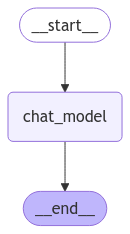

In [4]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Zeeshan

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are many fascinating ocean mammals beyond whales. Here are some examples:

1. **Dolphins**: These intelligent and social creatures are closely related to whales and are known for their playful behavior.
2. **Porpoises**: Smaller than dolphins, porpoises are also toothed cetaceans that are often mistaken for dolphins.
3. **Manatees**: Also known as sea cows, manatees are large, slow-moving aquatic mammals that feed on seaweed and seagrass.
4. **Dugongs**: Similar to manatees, dugongs are large, herbivorous mammals that are found in tropical waters.
5. **Seals and Sea Lions**: These pinnipeds (fin-footed ma

## Reducer

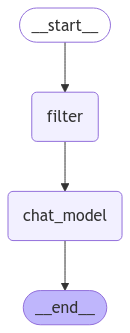

In [6]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Zeeshan", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Zeeshan", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Zeeshan

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are many fascinating ocean mammals beyond whales. Here are some examples:

1. **Dolphins**: These intelligent and social creatures are closely related to whales and are known for their playful behavior.
2. **Porpoises**: Smaller than dolphins, porpoises are also toothed cetaceans that are often mistaken for dolphins.
3. **Manatees**: Also known as sea cows, manatees are large, slow-moving aquatic mammals that feed on seaweed and seagrass.
4. **Dugongs**: Similar to manatees, dugongs are large, herbivorous mammals that are found in tropical waters.
5. **Seals and Sea Lions**: These pinnipeds (fin-footed ma

## Filtering messages

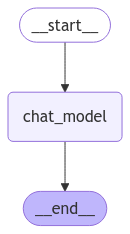

In [8]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Zeeshan"))

In [10]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Zeeshan

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Zeeshan

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are many fascinating ocean mammals beyond whales. Here are some examples:

1. **Dolphins**: These intelligent and social creatures are closely related to whales and are known for their playful behavior.
2. **Porpoises**: Smaller than dolphins, porpoises are also toothed cetaceans that are often mistaken for dolphins.
3. **Manatees**: Also known as sea cows, manatees are large, slow-moving aquatic mammals that fee

In [11]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Zeeshan

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Zeeshan

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are many fascinating ocean mammals beyond whales. Here are some examples:

1. **Dolphins**: These intelligent and social creatures are closely related to whales and are known for their playful behavior.
2. **Porpoises**: Smaller than dolphins, porpoises are also toothed cetaceans that are often mistaken for dolphins.
3. **Manatees**: Also known as sea cows, manatees are large, slow-moving aquatic mammals that fee

## Trim messages


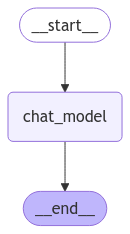

In [12]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatGroq(model="llama-3.1-8b-instant"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Zeeshan"))

In [ ]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatGroq(model="llama-3.1-8b-instant"),
            allow_partial=False
        )

In [16]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})